In [64]:
import numpy as np
import random
import scipy.io as spio
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score, mean_squared_error
INF = np.inf

#Read data 
mat = spio.loadmat('MUTAG.mat', squeeze_me=True)
type(mat)
mutag = mat['MUTAG']
lmutag = mat['lmutag']
N = np.size(mutag)

#get phi size 
tol = 0
#get total number of nodes in the dataset  
for i in range(N):
    graph = mutag[i]
    tol += len(graph[1].tolist()[0])


#wl subtree kernel of two graphs  
def wl_substree_kernel (m1, m2, tol, H):  
    K = 0 
    l1 = np.zeros(m1.shape[0])
    l2 = np.zeros(m1.shape[0])
    
    #---------------- Original Count -----------------------
    Map = dict(); #Key(string): true label; Value(int): label compression 
    ctr = 0 #label compression 
    
    #phi for original node labels counts 
    phi1 = np.zeros(tol)
    phi2 = np.zeros(tol) 
    
    #for graph1 
    labels1 = np.zeros(l1.shape[0])
    for i in range(l1.shape[0]): 
        str_label = str(l1[i])  #convert to string 
        if (str_label in Map): 
            labels1[i] = Map[str_label]
        else: 
            Map[str_label] = ctr 
            labels1[i] = ctr
            ctr += 1
        
    labels1 = np.int64(labels1)
    phi1[labels1] += 1
    
    
    #for graph2
    labels2 = np.zeros(l2.shape[0])
    for i in range(l2.shape[0]): 
        str_label = str(l2[i])  #convert to string 
        if (str_label in Map): 
            labels2[i] = Map[str_label]
        else: 
            Map[str_label] = ctr 
            labels2[i] = ctr
            ctr += 1
        
    labels2 = np.int64(labels2)
    phi2[labels2] += 1
    

    K += np.dot(phi1.T, phi2)
    
    #---------------- H iteration -----------------------
    new_labels1 = labels1
    new_labels2 = labels2
    
    for h in range(H):
        
        #Map = dict(); ctr = 0 
        
        #phi for h-th iteration
        phi1 = np.zeros(tol)
        phi2 = np.zeros(tol) 
        
        #for graph 1
        for i in range(l1.shape[0]): 
            #find the labels of neighbors
            neighbors_label = labels1[np.where(m1[i] == 1)]
            long_label = np.concatenate((np.array([labels1[i]]), neighbors_label))
            str_label = str(long_label)

            #check map 
            if (str_label in Map): 
                new_labels1[i] = Map[str_label]
            else: 
                Map[str_label] = ctr 
                new_labels1[i] = ctr
                ctr += 1

            phi1[np.int64(new_labels1)] += 1
            
        
        #for graph 2
        for i in range(l2.shape[0]): 
            #find the labels of neighbors
            neighbors_label = labels2[np.where(m2[i] == 1)]
            long_label = np.concatenate((np.array([labels2[i]]), neighbors_label))
            str_label = str(long_label)

            #check map 
            if (str_label in Map): 
                new_labels2[i] = Map[str_label]
            else: 
                Map[str_label] = ctr 
                new_labels2[i] = ctr
                ctr += 1

            phi2[np.int64(new_labels2)] += 1
            
            
        K += np.dot(phi1.T, phi2)
        
        labels1 = new_labels1
        labels2 = new_labels2
        labels1 = np.int64(labels1)
        labels2 = np.int64(labels2)
    
    return K 

**Experiment setup** We assessed the behaviour on randomly generated graphs with respect to four parameters: data set size N, graph size n, subtree height h and graph density c.

In [38]:
N_set = np.array([10, 100, 1000])
n_set = [(x + 1)*100 for x in list(range(10))]
h_set = np.array([2, 4, 8])
c_set = [(x + 1)*0.1 for x in list(range(9))]


def get_am(n, c, seed): 
    am = np.zeros([n, n])
    max_num_edges = int((n*(n-1))/2)
    num_edges = int(round(max_num_edges * c ))
    
    random.seed(seed) 
    samples = random.sample(range(max_num_edges), num_edges)
    
    for x in samples:  
        row = x // n 
        col = x % n
        am[row, col] = 1 
        am[col, row] = 1 
    return am 

#get_am(10, 0.1, 1) 

In [83]:
import time
def get_running_time(N, n, h, c, phi_size): 
    all_am = [0]*N 
    for i in range(N): 
        all_am[i] = get_am(n, c, i) 
    
    K = np.zeros([N, N])
    
    start_time = time.time()
    for i in range(N): 
        for j in range(N): 
            m1 = all_am[i]
            m2 = all_am[j] 
            K[i, j] = wl_substree_kernel(m1, m2, phi_size, h)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    return (time.time() - start_time)

In [136]:
#graph 1 
time_set = [] 
for N in N_set: 
    #default setting  
    n = 20; h = 2; c = 0.4 
    t = get_running_time(N, n, h, c, tol)
    print(t)
    time_set.append(t)

--- 0.750575065612793 seconds ---
0.7506771087646484
--- 48.27554512023926 seconds ---
48.275652170181274
--- 4790.8440001010895 seconds ---
4790.844105005264


In [142]:
#graph 2
time_set_2 = [] 
for n in n_set: 
    #default setting  
    N = 10; h = 4; c = 0.4 
    t = get_running_time(N, n, h, c, n*N)
    print(t)
    time_set_2.append(t)

--- 11.08481502532959 seconds ---
11.086519002914429
--- 31.650201082229614 seconds ---
31.65030598640442
--- 65.42501616477966 seconds ---
65.42516827583313
--- 118.66686081886292 seconds ---
118.66696882247925
--- 173.33963918685913 seconds ---
173.339830160141
--- 248.88680505752563 seconds ---
248.8869183063507
--- 352.9539740085602 seconds ---
352.9540972709656
--- 453.4470269680023 seconds ---
453.44716596603394
--- 575.6846969127655 seconds ---
575.6848452091217
--- 777.9198479652405 seconds ---
777.9199738502502


In [88]:
#graph 3
time_set_3 = [] 
for h in h_set: 
    #default setting  
    N = 10; n = 100; c = 0.4 
    t = get_running_time(N, n, h, c, n*N*h)
    print(t)
    time_set_3.append(t)

--- 5.378842830657959 seconds ---
5.378952980041504
--- 10.808762788772583 seconds ---
10.808862924575806
--- 25.752474069595337 seconds ---
25.752580165863037


In [140]:
#graph 4
c_set = [(x + 1)*0.1 for x in list(range(9))]

time_set_4 = [] 
for c in c_set: 
    #default setting  
    N = 10; n = 100; h = 4 
    t = get_running_time(N, n, h, c, 1000)
    print(t)
    time_set_4.append(t)

--- 5.723060846328735 seconds ---
5.7231669425964355
--- 6.874244928359985 seconds ---
6.874346971511841
--- 8.283513069152832 seconds ---
8.285286903381348
--- 9.148592948913574 seconds ---
9.148698806762695
--- 10.194782972335815 seconds ---
10.194889068603516
--- 11.751205205917358 seconds ---
11.751322031021118
--- 13.658163070678711 seconds ---
13.65826416015625
--- 14.63727617263794 seconds ---
14.637376070022583
--- 15.204340934753418 seconds ---
15.20444107055664


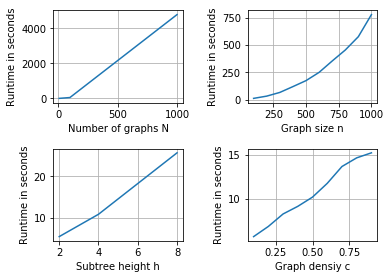

In [143]:
fig = plt.figure()
plt.figure(1)

plt.subplot(221)
plt.plot(N_set, time_set)
plt.xlabel('Number of graphs N')
plt.ylabel('Runtime in seconds')
plt.grid()

plt.subplot(222)
plt.plot(n_set, time_set_2)
plt.xlabel('Graph size n')
plt.ylabel('Runtime in seconds')
plt.grid()

plt.subplot(223)
plt.plot(h_set, time_set_3)
plt.xlabel('Subtree height h')
plt.ylabel('Runtime in seconds')
plt.grid()

plt.subplot(224)
plt.plot(c_set, time_set_4)
plt.xlabel('Graph densiy c')
plt.ylabel('Runtime in seconds')
plt.grid()

plt.subplots_adjust(left = 0.15, right=0.9, bottom=0.1, top=0.9,
                   wspace = 0.5, hspace = 0.5 )


plt.show()
fig.savefig('runtime.png')